In [2]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd /content/gdrive/My Drive/DLProjects/JapaNet

Mounted at /content/gdrive
/content/gdrive/My Drive/DLProjects/JapaNet


In [3]:
df_train = pd.read_csv('data/train.csv')
df_train.head()

,image_id,labels
0,100241706_00004_2,U+306F 1231 3465 133 53 U+304C 275 1652 84 69 ...
1,100241706_00005_1,U+306F 1087 2018 103 65 U+304B 1456 1832 40 73...
2,100241706_00005_2,U+306F 572 1376 125 57 U+306E 1551 2080 69 68 ...
3,100241706_00006_1,U+3082 1455 3009 65 44 U+516B 1654 1528 141 75...
4,100241706_00007_2,U+309D 1201 2949 27 33 U+309D 1196 1539 27 36 ...


In [130]:
import argparse
import pandas as pd
import numpy as np
import tensorflow as tf
import importlib
from tqdm.auto import tqdm
from PIL import Image
import io
import random


def image2Bytes(image):
    buffer = io.BytesIO()
    image.save(buffer, format='JPEG')
    return buffer.getvalue()


def _bytesFeature(value):
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))


def _floatFeature(value):
    return tf.train.Feature(float_list=tf.train.FloatList(value=value))


class IdentifierDataset:
    def __init__(self, config):
        self.config = config
        self.trainRecordPath = 'data/train/train.tfrecord'
        self.validationRecordPath = 'data/train/validation.tfrecord'
        self.feature_description = {
            'image': tf.io.FixedLenFeature([], dtype=tf.string),
            'labels': tf.io.FixedLenFeature([128 * 128 * 5], dtype=tf.float32)
        }
        self._trainWriter = None
        self._validationWriter = None

    def _write(self, image, label):
        feature = {
            'image': _bytesFeature(image),
            'labels': _floatFeature(label.ravel())
        }
        sample = tf.train.Example(features=tf.train.Features(feature=feature))
        if random.random() < self.config['validationFraction']:
            self._validationWriter.write(sample.SerializeToString())
        else:
            self._trainWriter.write(sample.SerializeToString())

    def _createLabel(self, rawLabel, resizedRatioWidth=1.0, resizedRatioHeight=1.0):
        outputWidth = self.config['identifierInputWidth'] // self.config['identifierOutputStride']
        outputHeight = self.config['identifierInputHeight'] // self.config['identifierOutputStride']
        pageData = np.array(rawLabel.split(" ")).reshape(-1, 5)
        pageData = pageData[:, 1:].astype('uint32')
        pageData[:, [0, 2]] = pageData[:, [0, 2]] // resizedRatioWidth
        pageData[:, [1, 3]] = pageData[:, [1, 3]] // resizedRatioHeight
        xCenters = pageData[:, 0] + pageData[:, 2] // 2  # Center on X
        yCenters = pageData[:, 1] + pageData[:, 3] // 2  # Center on Y
        heatMapXCenters = (xCenters / self.config['identifierOutputStride']).astype(np.uint32)
        heatMapYCenters = (yCenters / self.config['identifierOutputStride']).astype(np.uint32)
        xOffset = (xCenters / self.config['identifierOutputStride'] - heatMapXCenters)
        yOffset = (yCenters / self.config['identifierOutputStride'] - heatMapYCenters)
        xSizes = pageData[:, 2] / self.config['identifierOutputStride']
        ySizes = pageData[:, 3] / self.config['identifierOutputStride']

        label = np.zeros((outputHeight, outputWidth, 5))
        for i in range(len(xCenters)):
            xCenter = heatMapXCenters[i]
            yCenter = heatMapYCenters[i]
            heatMap = ((np.exp(-(((np.arange(outputWidth) - xCenter) / (xSizes[i] / 10)) ** 2) / 2)).reshape(1, -1)
                       * (np.exp(-(((np.arange(outputHeight) - yCenter) / (ySizes[i] / 10)) ** 2) / 2)).reshape(-1, 1))
            label[:, :, 0] = np.maximum(label[:, :, 0], heatMap)
            label[yCenter, xCenter, 1] = xSizes[i] / outputWidth
            label[yCenter, xCenter, 2] = ySizes[i] / outputHeight
            label[yCenter, xCenter, 3] = xOffset[i] / outputWidth
            label[yCenter, xCenter, 4] = yOffset[i] / outputHeight
        return label

    def _processSample(self, rawSample):
        # Resizes image, gets its JPEG compressed data, and computes the new bounding boxes after resizing
        image = Image.open("data/train/" + rawSample['image_id'] + ".jpg")
        originalWidth = image.size[0]
        originalHeight = image.size[1]
        resizedImage = image.resize((self.config['identifierInputWidth'], self.config['identifierInputHeight']))
        imageBytes = image2Bytes(resizedImage)
        # Creates label (heatmap, xSize, ySize, xOffset, yOffset)
        label = self._createLabel(rawSample['labels'], originalWidth / self.config['identifierInputWidth'],
                                  originalHeight / self.config['identifierInputHeight'])
        return imageBytes, label

    def createDataset(self):
        dfTrain = pd.read_csv('data/train.csv')
        self._trainWriter = tf.io.TFRecordWriter(self.trainRecordPath)
        self._validationWriter = tf.io.TFRecordWriter(self.validationRecordPath)
        for i in tqdm(range(len(dfTrain))):
            sample = dfTrain.iloc[i]
            imageBytes, label = self._processSample(sample)
            self._write(imageBytes, label)
        self._trainWriter.flush()
        self._trainWriter.close()
        self._validationWriter.flush()
        self._validationWriter.close()

    def _processExample(self, example):
        pmap = tf.io.parse_single_example(example, self.feature_description)
        imageDecoded = tf.image.decode_jpeg(pmap['image'], channels=3) / 255
        imageResized = tf.image.resize(imageDecoded, [self.config['identifierInputWidth'],
                                                      self.config['identifierInputHeight']])
        outputWidth = self.config['identifierInputWidth'] // self.config['identifierOutputStride']
        outputHeight = self.config['identifierInputHeight'] // self.config['identifierOutputStride']
        label = tf.reshape(pmap['labels'], (outputWidth, outputHeight, 5))
        return imageResized, label

    def load(self):
        trainRecord = tf.data.TFRecordDataset(self.trainRecordPath)
        trainData = trainRecord.map(self._processExample, num_parallel_calls=tf.data.experimental.AUTOTUNE)
        trainData = trainData.shuffle(buffer_size=self.config['shufflingBufferSize'])
        trainData = trainData.batch(self.config['batchSize'], drop_remainder=True)
        trainData = trainData.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
        validationRecord = tf.data.TFRecordDataset(self.trainRecordPath)
        validationData = validationRecord.map(self._processExample, num_parallel_calls=tf.data.experimental.AUTOTUNE)
        validationData = validationData.batch(self.config['batchSize'], drop_remainder=True)
        validationData = validationData.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
        return trainData, validationData

In [131]:
datasetParams = {
    'shufflingBufferSize': 100,
    'batchSize': 32,
    'identifierInputHeight': 512,
    'identifierInputWidth': 512,
    'identifierOutputStride': 4,
    'validationFraction': 0.2
}


dataset = IdentifierDataset(datasetParams)
dataset.createDataset()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:70: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:70: RuntimeWarning: invalid value encountered in true_divide


In [132]:
!du -sh {'data/train/train.tfrecord'}
!du -sh {'data/train/validation.tfrecord'}

1.1G	data/train/train.tfrecord
258M	data/train/validation.tfrecord


In [133]:
dataset = IdentifierDataset(datasetParams)
trainData, validationData = dataset.load()

(32, 512, 512, 3)


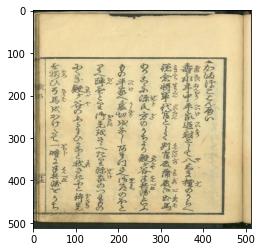

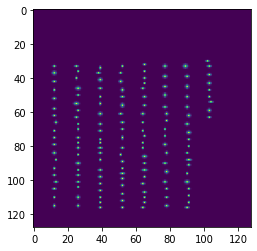

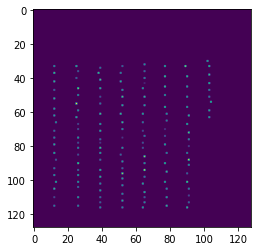

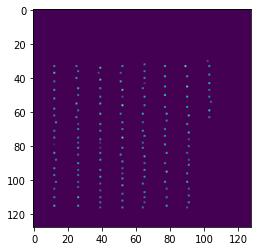

In [134]:
data, label = trainData.as_numpy_iterator().next()
print(data.shape)
data[0].shape
plt.imshow(data[0])
plt.figure()
plt.imshow(label[0][:, :, 0])
plt.figure()
plt.imshow(label[0][:, :, 1])
plt.figure()
plt.imshow(label[0][:, :, 2])

(32, 512, 512, 3)


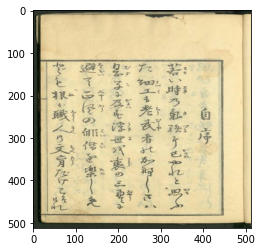

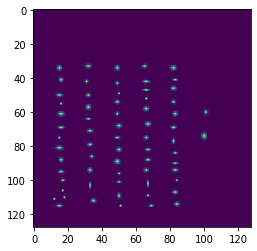

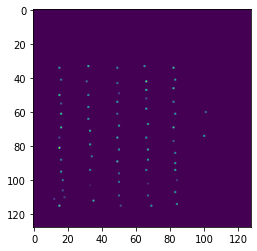

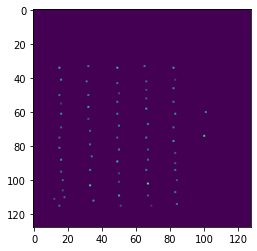

In [135]:
data, label = validationData.as_numpy_iterator().next()
print(data.shape)
data[0].shape
plt.imshow(data[0])
plt.figure()
plt.imshow(label[0][:, :, 0])
plt.figure()
plt.imshow(label[0][:, :, 1])
plt.figure()
plt.imshow(label[0][:, :, 2])